In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

In [2]:
# 策略继承CtaTemplate
class MultiKlineStrategy(CtaTemplate):
    className = 'MultiKlineStrategy'
    author = 'howers'
    # 策略参数
    trailingPct = 0.193  
    lot = 1
    # 策略变量 
    candle60= {};candle30= {}
    candle15= {}
    transactionPrice = {} # 记录成交价格
    # 参数列表，保存了参数的名称
    paramList = [
                 'trailingPct'
                ]    
    # 变量列表，保存了变量的名称
    varList = [
               'candle60','candle30',
               'candle15',
               'transactionPrice'
              ]  
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.candle60 = {s:0 for s in self.symbolList}
        self.candle30 = {s:0 for s in self.symbolList}
        self.candle15 = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s: 0 for s in self.symbolList}
        self.intraTradeLowDict = {s: 999999 for s in self.symbolList}
        self.putEvent()
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        # 计算止损止盈价位
        # 变量初始化
        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999
        # 持有多头仓位
        elif self.posDict[symbol + "_LONG"] > 0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            longStop = self.intraTradeHighDict[symbol] * (1-self.trailingPct)
            if bar.low <= longStop:
#                 print('longStop')
                self.cancelAll()
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            shortStop = self.intraTradeLowDict[symbol] * (1 + self.trailingPct)
            if bar.high >= shortStop:
#                 print('shortStop')
                self.cancelAll()
                self.cover(symbol, bar.close * 1.01, self.posDict[symbol + "_SHORT"])
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m")
        if not am60.inited:
            return
        # 计算均线并判断趋势
        lowlead = ((min(am60.close[-1],am60.open[-1])-am60.low[-1])/(am60.high[-1]-am60.low[-1]))>0.67and(am60.open[-1]-am60.close[-1]>0)                 
        toplead = ((am60.high[-1]-max(am60.close[-1],am60.open[-1]))/(am60.high[-1]-am60.low[-1]))>0.67 and(am60.open[-1]-am60.close[-1]<0) 
        #定义事件信号
        if lowlead:
            self.candle60[symbol] = 100
        elif toplead:
            self.candle60[symbol] = -100
    #----------------------------------------------------------------------
    def on30MinBar(self, bar):
        """收到30MinBar推送"""
        symbol = bar.vtSymbol
        am30 = self.getArrayManager(symbol, "30m")
        if not am30.inited:
            return
        darkcloudcover = ta.CDLDARKCLOUDCOVER(am30.open, am30.high, am30.low, am30.close, penetration=0)
        harami=ta.CDLHARAMI(am30.open, am30.high, am30.low, am30.close)   
        haramicross=ta.CDLHARAMICROSS(am30.open, am30.high, am30.low, am30.close)   
        piercing = ta.CDLPIERCING(am30.open, am30.high, am30.low, am30.close)   
        #定义事件信号
        self.candle30[symbol]=darkcloudcover+piercing+harami+haramicross
    
        #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        am15 = self.getArrayManager(symbol, "15m")
        if not am15.inited:
            return
        eveningdojistar=ta.CDLEVENINGDOJISTAR(am15.open, am15.high, am15.low, am15.close, penetration=0) 
        stalledpattern = ta.CDLSTALLEDPATTERN(am15.open, am15.high, am15.low, am15.close)  
        tasukigap = ta. CDLTASUKIGAP(am15.open, am15.high, am15.low, am15.close) 
        xsidegap3methods = ta.CDLXSIDEGAP3METHODS(am15.open, am15.high, am15.low, am15.close) 
        threeoutside= ta.CDL3OUTSIDE(am15.open, am15.high, am15.low, am15.close)  
        tristar= ta.CDLTRISTAR(am15.open, am15.high, am15.low, am15.close) 
        unique3rever=ta.CDLUNIQUE3RIVER(am15.open, am15.high, am15.low, am15.close) 
        
        self.candle15[symbol]=eveningdojistar+stalledpattern+tasukigap+xsidegap3methods+threeoutside+tristar+unique3rever
        
        Signal=self.candle15[symbol]+self.candle30[symbol]+self.candle60[symbol]
        
        if (Signal[-1]<=-200) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        if (Signal[-1]>=200) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiKlineStrategy.on60MinBar at 0x00000270164F0EA0>, <__main__.MultiKlineStrategy object at 0x000002701652CA20>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiKlineStrategy.on30MinBar at 0x00000270164F0D90>, <__main__.MultiKlineStrategy object at 0x000002701652CA20>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiKlineStrategy.on15MinBar at 0x00000270164F0F28>, <__main__.MultiKlineStrategy object at 0x000002701652CA20>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiKlineStrategy.onBar at 0x00000270164F0E18>, <__main__.MultiKlineStrategy object at 0x000002701652CA20>)
2018-12-16 20:49:06.557782	开始回测
2018-12-16 20:49:06.557782	策略初始化
2018-12-16 20:49:06.558783	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-16 20:49:08.044027	 当前品种 BTCUSDT:binance 的数据，全部来自于本地

2018-09-12 19:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-09-16 13:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-09-18 14:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-09-21 03:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-09-22 21:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-09-24 23:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-09-28 05:00:00.191451	Progress: 65%     {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-09-29 06:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-09-29 20:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-10-02 09:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-10-03 15:30:00.719810	Progress: 68%     {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-10-08 01:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-10-08 15:45:00 {'BTCUSDT:binance_

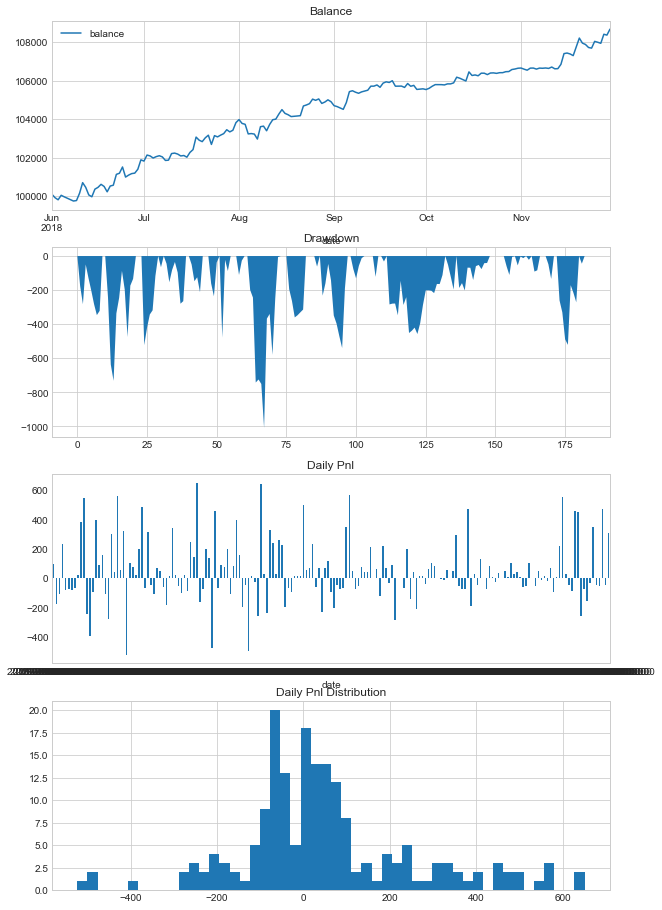

2018-12-16 20:50:01.065624	计算回测结果
2018-12-16 20:50:01.094643	------------------------------
2018-12-16 20:50:01.095645	第一笔交易：	2018-06-07 22:15:00
2018-12-16 20:50:01.095645	最后一笔交易：	2018-11-30 23:58:00
2018-12-16 20:50:01.095645	总交易次数：	97
2018-12-16 20:50:01.095645	总盈亏：	8,666.26
2018-12-16 20:50:01.095645	最大回撤: 	-796.27
2018-12-16 20:50:01.095645	平均每笔盈利：	89.34
2018-12-16 20:50:01.095645	平均每笔滑点：	0.0
2018-12-16 20:50:01.095645	平均每笔佣金：	6.42
2018-12-16 20:50:01.095645	胜率		54.64%
2018-12-16 20:50:01.095645	盈利交易平均值	260.98
2018-12-16 20:50:01.095645	亏损交易平均值	-117.41
2018-12-16 20:50:01.095645	盈亏比：	2.22


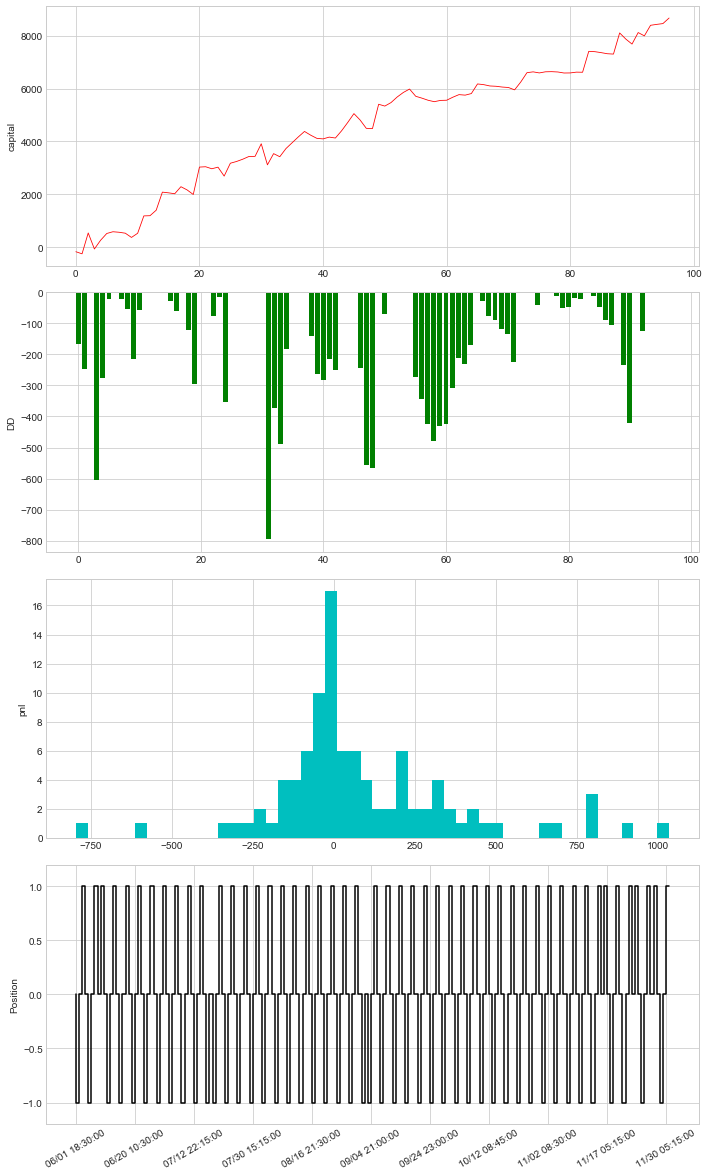

2018-12-16 20:50:02.263423	计算按日统计结果


(                netPnl  slippage  commission  turnover  tradeCount  \
 date                                                                 
 2018-06-01   96.714105     0.002    3.773895   7547.79           1   
 2018-06-02 -175.800000     0.000    0.000000      0.00           0   
 2018-06-03 -106.910000     0.000    0.000000      0.00           0   
 2018-06-04  233.020000     0.000    0.000000      0.00           0   
 2018-06-05  -80.100000     0.000    0.000000      0.00           0   
 2018-06-06  -73.410000     0.000    0.000000      0.00           0   
 2018-06-07  -79.640930     0.004    7.706930  15413.86           2   
 2018-06-08  -63.920000     0.000    0.000000      0.00           0   
 2018-06-09   25.070890     0.004    7.635110  15270.22           2   
 2018-06-10  381.220000     0.000    0.000000      0.00           0   
 2018-06-11  546.780000     0.000    0.000000      0.00           0   
 2018-06-12 -243.483320     0.004    6.839320  13678.64           2   
 2018-

In [3]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd
def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf
parameterDict = {'symbolList':['BTCUSDT:binance']}
runBacktesting(MultiKlineStrategy, parameterDict, '20180601 00:00', '20181201 00:00', 0.002, 5/10000)

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiKlineStrategy.on60MinBar at 0x0000027029FFD598>, <__main__.MultiKlineStrategy object at 0x0000027027BEBBE0>)
[DEBUG] 注册品种EOSUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiKlineStrategy.on30MinBar at 0x0000027029FFD6A8>, <__main__.MultiKlineStrategy object at 0x0000027027BEBBE0>)
[DEBUG] 注册品种EOSUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiKlineStrategy.on15MinBar at 0x000002702A3762F0>, <__main__.MultiKlineStrategy object at 0x0000027027BEBBE0>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function MultiKlineStrategy.onBar at 0x0000027029FFDD90>, <__main__.MultiKlineStrategy object at 0x0000027027BEBBE0>)
2018-12-16 20:50:17.807978	开始回测
2018-12-16 20:50:17.807978	策略初始化
2018-12-16 20:50:17.808978	载入历史数据。数据范围:[20180622 16:00,20180701 00:00)
2018-12-16 20:50:18.871269	 当前品种 EOSUSDT:binance 的数据，全部来自于本地

Traceback (most recent call last):
  File "D:\Users\Administrator\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "D:\Users\Administrator\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


2018-12-16 20:50:34.888317	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 20:50:34.889317	载入完成，数据量：3789
[INFO] 品种EOSUSDT:binance的历史1mK线更新，范围为:[20180630222100 , 20180701000000]
[INFO] 品种EOSUSDT:binance的1mK线准备就绪,当前K线时间为20180701000000
[INFO] 品种EOSUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180701000000
2018-12-16 20:50:34.913332	载入历史数据。数据范围:[20180524 03:00,20180630 08:50)
2018-12-16 20:50:37.962545	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-16 20:50:37.973559	载入完成，数据量：46565
2018-12-16 20:50:37.978566	载入历史数据。数据范围:[20180703 00:01,20180703 01:00)
2018-12-16 20:50:37.985573	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 20:50:37.985573	！！ 数据量为 0 ！！


Traceback (most recent call last):
  File "D:\Users\Administrator\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "D:\Users\Administrator\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180626090000 , 20180630230000]
[INFO] 品种EOSUSDT:binance开始生成未完成的30mK线数据,时间起点为:20180701000000
[INFO] 品种EOSUSDT:binance的历史30mK线更新，范围为:[20180628220000 , 20180630233000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180701000000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180629230000 , 20180630234500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180701000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180701000000
[INFO] 品种EOSUSDT:binance开始生成30mK线数据,时间起点为:20180701000000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180701000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 8.0545, 'high': 8.0734, 'low': 7.9800000000000004, 'close': 8.0295000000000005, 'date': '20180701', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 7, 1, 0, 0), 'volume': 93490.430000000008, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180629231500 , 20180701000

2018-10-15 09:00:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 1}
2018-10-16 08:15:00 {'EOSUSDT:binance_LONG': 1, 'EOSUSDT:binance_SHORT': 0}
2018-10-17 14:15:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 1}
2018-10-23 13:30:00 {'EOSUSDT:binance_LONG': 1, 'EOSUSDT:binance_SHORT': 0}
2018-10-24 16:15:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 1}
2018-10-26 07:30:00 {'EOSUSDT:binance_LONG': 1, 'EOSUSDT:binance_SHORT': 0}
2018-10-27 00:45:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 1}
2018-10-27 21:45:00 {'EOSUSDT:binance_LONG': 1, 'EOSUSDT:binance_SHORT': 0}
2018-10-28 01:30:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 1}
2018-10-29 08:00:00 {'EOSUSDT:binance_LONG': 1, 'EOSUSDT:binance_SHORT': 0}
2018-11-01 08:15:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 1}
2018-11-02 05:30:00.973544	Progress: 82%     {'EOSUSDT:binance_LONG': 1, 'EOSUSDT:binance_SHORT': 0}
2018-11-03 13:00:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binanc

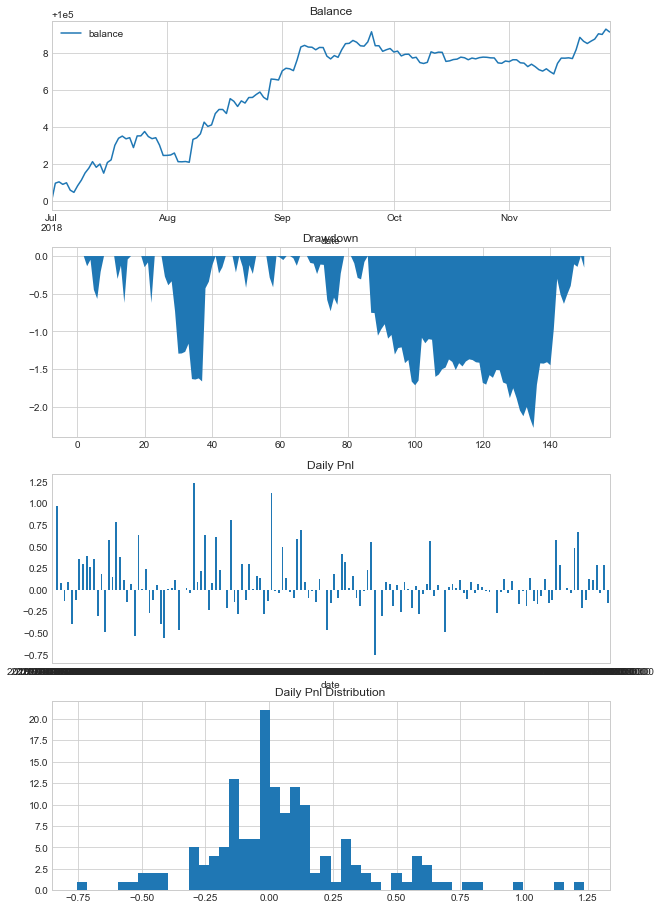

2018-12-16 20:51:04.286078	计算回测结果
2018-12-16 20:51:04.298179	------------------------------
2018-12-16 20:51:04.298179	第一笔交易：	2018-07-03 21:00:00
2018-12-16 20:51:04.298179	最后一笔交易：	2018-11-28 23:58:00
2018-12-16 20:51:04.298179	总交易次数：	108
2018-12-16 20:51:04.298179	总盈亏：	9.13
2018-12-16 20:51:04.298179	最大回撤: 	-1.98
2018-12-16 20:51:04.298179	平均每笔盈利：	0.08
2018-12-16 20:51:04.298179	平均每笔滑点：	0.0
2018-12-16 20:51:04.298179	平均每笔佣金：	0.01
2018-12-16 20:51:04.298179	胜率		45.37%
2018-12-16 20:51:04.298179	盈利交易平均值	0.37
2018-12-16 20:51:04.298179	亏损交易平均值	-0.15
2018-12-16 20:51:04.298179	盈亏比：	2.42


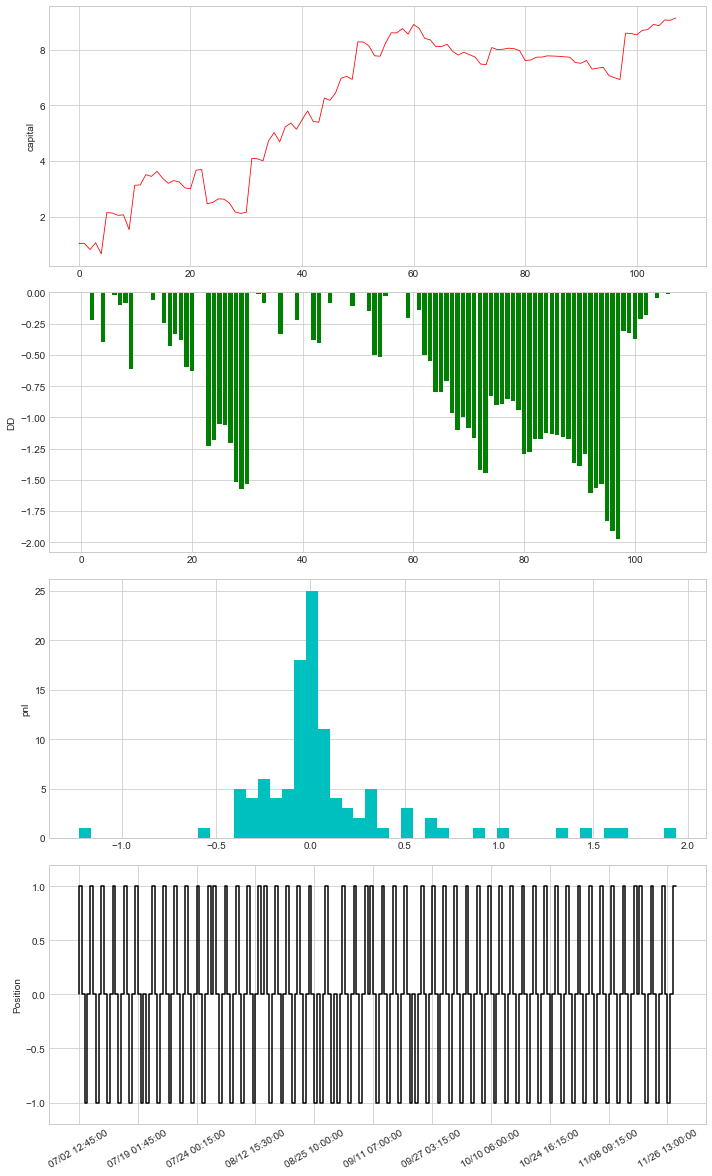

2018-12-16 20:51:05.276825	计算按日统计结果


(              netPnl  slippage  commission  turnover  tradeCount  tradingPnl  \
 date                                                                           
 2018-07-01  0.000000     0.000    0.000000    0.0000           0      0.0000   
 2018-07-02  0.964022     0.002    0.003978    7.9568           1      0.9700   
 2018-07-03  0.072394     0.004    0.009006   18.0112           2      0.0132   
 2018-07-04 -0.135500     0.000    0.000000    0.0000           0      0.0000   
 2018-07-05  0.085705     0.004    0.008995   17.9896           2     -0.0820   
 2018-07-06 -0.397900     0.000    0.000000    0.0000           0      0.0000   
 2018-07-07 -0.120700     0.000    0.000000    0.0000           0      0.0000   
 2018-07-08  0.358600     0.000    0.000000    0.0000           0      0.0000   
 2018-07-09  0.300975     0.008    0.017325   34.6494           4      0.5150   
 2018-07-10  0.388752     0.004    0.008148   16.2960           2      1.7160   
 2018-07-11  0.257900     0.

In [4]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd
def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf
parameterDict = {'symbolList':['EOSUSDT:binance']}
runBacktesting(MultiKlineStrategy, parameterDict, '20180701 00:00', '20181201 00:00', 0.002, 5/10000)